In [30]:
import numpy as np # Pour la manipulation de tableaux
from keras.applications import  resnet50
from sklearn import metrics 
import os

import pandas as pd # Pour manipuler des DataFrames pandas

import matplotlib.pyplot as plt # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur
%matplotlib inline

from keras.models import Sequential # Pour construire un réseau de neurones
from keras.layers import Dense, Conv2D # Pour instancier une couche dense
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense, Activation,GlobalAveragePooling2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.models import Model
import cv2
import keras
from numpy.random import seed
import tensorflow

from keras.preprocessing.image import ImageDataGenerator
import itertools # Pour créer des iterateurs

from sklearn import linear_model, preprocessing 



%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import time, cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras import backend as K
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input

In [121]:
#Paramètres
base_img_paths="/home/marcpozzo/Desktop/c3po/Images_aquises/"
generateur_path='/mnt/VegaSlowDataDisk/c3po/Chaine_de_traitement/Train_imagettes_annotées/type_oiseau/Materiel/generateur.csv'
test_size=0.01
epochs=5
batch_size = 600
class_mode="sparse"
zoom_range = 1.1
horizontal_flip = False
Minimum_Number_Class=100
dropout_rate=0

#steps_per_epoch=1

#validation_steps=1

In [43]:
#df=pd.read_csv("/home/marcpozzo/Desktop/c3po/Images_aquises/generateur.csv")


In [44]:
df=pd.read_csv(generateur_path)
print(pd.isnull(df).sum())
#df.drop('labels',inplace=True,axis=1)
for i in df["labels"].unique():
    print(i,len(df["labels"][df["labels"]==i]))

Non_utilisable=['Abeille', 'chat','leaf','shadow','sanglier', 'rock','other', 'plastic','autre', 'ciel', 'ombre','cheval','avion']

for i in Non_utilisable:
    df=df[df["labels"]!=i]
df["labels"].unique()

df["class"]=df["class"].replace("pie","oiseau")
df["class"][df["labels"]=="voiture"]="voiture"
df["class"][df["labels"]=="tracteur"]="tracteur"
print(len(df["class"].unique()))
df
          
          
          
          
df["class"].unique()
to_change=['chat','abeille','sanglier','cheval']
df["class"]=df["class"].replace(to_change,"autre_animaux")
len(df[df["class"]=="autre_animaux"])
df1=df[df["class"]!="autre_animaux"]
df1["labels"].unique()

df["class"].unique()
for c in df:
    print(''+c+':',len(df[c].unique()))
df["labels"].unique()



All_Unique=df["labels"].unique()
Utilisable=[]
for i in df["labels"].unique():
    if df["labels"][df["labels"]==i].count()>Minimum_Number_Class:
        Utilisable.append(i)
Utilisable
Non_Utilisable=set(All_Unique)-set(Utilisable)
Non_Utilisable
for i in Non_Utilisable:
    df=df[df["labels"]!=i]
#df=df[df["class"]!="oiseau"]  
df["labels"].unique()
for i in df["labels"].unique():
    print(i,len(df["labels"][df["labels"]==i]))
    

for i in range(len(df["class"])):
    image_name=df["img_paths"].iloc[i]
    df["img_paths"].iloc[i]=os.path.join(base_img_paths,image_name)
    
df.head()


#df["labels"][df["class"]=="autre"].unique()
data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)


validation_steps=len(data_test)//batch_size
steps_per_epoch=len(data_train)//batch_size

epochs=2
seed(1)
tensorflow.random.set_seed(2)
class_mode="sparse"

data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)
train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        # data augmentation
        #rotation_range = 10,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip
        )

test_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input)




train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode =class_mode,
                                                          target_size = (28 , 28), 
                                                          batch_size = batch_size)


test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode =class_mode,
                                                          target_size = (28 , 28), 
                                                          batch_size = batch_size)



lenet = Sequential()

conv_1 = Conv2D(filters = 30,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (28, 28, 3),       # Dimensions de l'image en entrée
                activation = 'relu')             # Fonction d'activation

max_pool_1 = MaxPooling2D(pool_size = (2, 2))

conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')

max_pool_2 = MaxPooling2D(pool_size = (2, 2))

flatten = Flatten()

dropout = Dropout(rate = dropout_rate)

dense_1 = Dense(units = 128,
                activation = 'relu')

dense_2 = Dense(units = 9,
                activation = 'softmax')

lenet.add(conv_1)
lenet.add(max_pool_1)
lenet.add(conv_2)
lenet.add(max_pool_2)
lenet.add(dropout)
lenet.add(flatten)
lenet.add(dense_1)
lenet.add(dense_2)

# Compilation
lenet.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation




history=lenet.fit_generator( train_generator,
                           steps_per_epoch=len(data_train)//batch_size,
                           epochs=epochs,
                           workers=-1,
                           validation_data=test_generator,
                           validation_steps=len(data_test)//batch_size)

def convert_image(X):
    X_img=[]
    for image in X:
        # Load image
        img=cv2.imread(image)
        # Resize image
        img=cv2.resize(img,(28,28))
        # for the black and white image
        if img.shape==(28, 28):
            img=img.reshape([28,28,1])
            img=np.concatenate([img,img,img],axis=2)
        # cv2 load the image BGR sequence color (not RGB)
        X_img.append(img[...,::-1])
    return np.array(X_img)

# Load the images train
X_train_img = convert_image(data_train.img_paths)
Y_train = data_train['class']

# Load the images test
X_test_img = convert_image(data_test.img_paths)
Y_test = data_test['class']

labels       0
class        0
img_paths    0
dtype: int64
incertain 216
ground 2975
corneille 1044
pigeon 828
pie 1
chat 2
Abeille 1
chevreuil 136
Corneille 4
Lapin 1
lapin 176
dirt 99
crow 25
leaf 12
shadow 9
faisan 335
oiseau 2
sanglier 4
rock 14
other 2
plastic 1
flying crow 1
autre 18
ciel 3
ombre 4
cheval 27
voiture 133
avion 6
tracteur 141
9
labels: 16
class: 9
img_paths: 6117
incertain 216
ground 2975
corneille 1044
pigeon 828
chevreuil 136
lapin 176
faisan 335
voiture 133
tracteur 141
Found 4787 validated image filenames belonging to 9 classes.
Found 1197 validated image filenames belonging to 9 classes.
Epoch 1/2
7/7 [==============================] - 5s 752ms/step - loss: 8.2414 - accuracy: 0.3107 - val_loss: 2.8698 - val_accuracy: 0.3267
Epoch 2/2
7/7 [==============================] - 5s 693ms/step - loss: 2.5875 - accuracy: 0.4091 - val_loss: 1.9683 - val_accuracy: 0.5293


In [34]:
df.head()

,labels,class,img_paths
0,incertain,oiseau,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
1,ground,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
2,corneille,corneille,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
3,corneille,corneille,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
4,pigeon,pigeon,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...


In [122]:
base_img_paths="/home/marcpozzo/Desktop/c3po/Images_aquises/"
generateur_path='/home/marcpozzo/Desktop/c3po/Images_aquises/generateur_bigger.csv'

df=pd.read_csv(generateur_path)
print(pd.isnull(df).sum())
#df.drop('labels',inplace=True,axis=1)
for i in df["labels"].unique():
    print(i,len(df["labels"][df["labels"]==i]))

Non_utilisable=['Abeille', 'chat','leaf','shadow','sanglier', 'rock','other', 'plastic','autre', 'ciel', 'ombre','cheval','avion']

for i in Non_utilisable:
    df=df[df["labels"]!=i]
df["labels"].unique()

df["class"]=df["class"].replace("pie","oiseau")
df["class"][df["labels"]=="voiture"]="voiture"
df["class"][df["labels"]=="tracteur"]="tracteur"
print(len(df["class"].unique()))
df
          
          
          
          
df["class"].unique()
to_change=['chat','abeille','sanglier','cheval']
df["class"]=df["class"].replace(to_change,"autre_animaux")
len(df[df["class"]=="autre_animaux"])
df1=df[df["class"]!="autre_animaux"]
df1["labels"].unique()

df["class"].unique()
for c in df:
    print(''+c+':',len(df[c].unique()))
df["labels"].unique()



All_Unique=df["labels"].unique()
Utilisable=[]
for i in df["labels"].unique():
    if df["labels"][df["labels"]==i].count()>Minimum_Number_Class:
        Utilisable.append(i)
Utilisable
Non_Utilisable=set(All_Unique)-set(Utilisable)
Non_Utilisable
for i in Non_Utilisable:
    df=df[df["labels"]!=i]
#df=df[df["class"]!="oiseau"]  
df["labels"].unique()
for i in df["labels"].unique():
    print(i,len(df["labels"][df["labels"]==i]))
    

for i in range(len(df["class"])):
    image_name=df["img_paths"].iloc[i]
    df["img_paths"].iloc[i]=os.path.join(base_img_paths,image_name)
    
df.head()

labels       0
class        0
img_paths    0
dtype: int64
incertain 216
ground 2975
corneille 1044
pigeon 828
pie 1
chat 2
Abeille 1
chevreuil 136
Corneille 4
Lapin 1
lapin 176
dirt 99
crow 25
leaf 12
shadow 9
faisan 335
oiseau 2
sanglier 4
rock 14
other 2
plastic 1
flying crow 1
autre 18
ciel 3
ombre 4
cheval 27
voiture 133
avion 6
tracteur 141
9
labels: 16
class: 9
img_paths: 6117
incertain 216
ground 2975
corneille 1044
pigeon 828
chevreuil 136
lapin 176
faisan 335
voiture 133
tracteur 141


,labels,class,img_paths
0,incertain,oiseau,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
1,ground,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
2,corneille,corneille,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
3,corneille,corneille,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
4,pigeon,pigeon,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...


In [123]:
#df["labels"][df["class"]=="autre"].unique()
data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)


validation_steps=len(data_test)//batch_size
steps_per_epoch=len(data_train)//batch_size

epochs=2
seed(1)
tensorflow.random.set_seed(2)
class_mode="sparse"

data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)
train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        # data augmentation
        #rotation_range = 10,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip
        )

test_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input)




train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode =class_mode,
                                                          target_size = (28 , 28), 
                                                          batch_size = batch_size)


test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode =class_mode,
                                                          target_size = (28 , 28), 
                                                          batch_size = batch_size)



lenet = Sequential()

conv_1 = Conv2D(filters = 30,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (28, 28, 3),       # Dimensions de l'image en entrée
                activation = 'relu')             # Fonction d'activation

max_pool_1 = MaxPooling2D(pool_size = (2, 2))

conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')

max_pool_2 = MaxPooling2D(pool_size = (2, 2))

flatten = Flatten()

dropout = Dropout(rate = dropout_rate)

dense_1 = Dense(units = 128,
                activation = 'relu')

dense_2 = Dense(units = 9,
                activation = 'softmax')

lenet.add(conv_1)
lenet.add(max_pool_1)
lenet.add(conv_2)
lenet.add(max_pool_2)
lenet.add(dropout)
lenet.add(flatten)
lenet.add(dense_1)
lenet.add(dense_2)

# Compilation
lenet.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation




history=lenet.fit_generator( train_generator,
                           steps_per_epoch=len(data_train)//batch_size,
                           epochs=epochs,
                           workers=-1,
                           validation_data=test_generator,
                           validation_steps=len(data_test)//batch_size)

/home/marcpozzo/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 5211 invalid image filename(s) in x_col="img_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/home/marcpozzo/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 52 invalid image filename(s) in x_col="img_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 713 validated image filenames belonging to 7 classes.
Found 8 validated image filenames belonging to 3 classes.
Epoch 1/2
9/9 [==============================] - 4s 430ms/step - loss: 8.5306 - accuracy: 0.3216 - val_loss: 6.4763 - val_accuracy: 0.3750
Epoch 2/2
9/9 [==============================] - 3s 343ms/step - loss: 1.9275 - accuracy: 0.4890 - val_loss: 4.5932 - val_accuracy: 0.5000


In [68]:
def convert_image(X):
    X_img=[]
    for image in X:
        # Load image
        img=cv2.imread(image)
        # Resize image
        img=cv2.resize(img,(28,28))
        # for the black and white image
        if img.shape==(28, 28):
            img=img.reshape([28,28,1])
            img=np.concatenate([img,img,img],axis=2)
        # cv2 load the image BGR sequence color (not RGB)
        X_img.append(img[...,::-1])
    return np.array(X_img)

# Load the images train
X_train_img = convert_image(data_train["img_paths"])
Y_train = data_train['class']

# Load the images test
X_test_img = convert_image(data_test.img_paths)
Y_test = data_test['class']

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [57]:
data_train=data_train[data_train["img_paths"]!=]

In [124]:
    data_train=data_train[data_train["img_paths"]!='/home/marcpozzo/Desktop/c3po/Images_aquises/Rec_images_bigger/EK000414_3_pigeon_178.JPG'] 
    data_train=data_train[data_train["img_paths"]!='/home/marcpozzo/Desktop/c3po/Images_aquises/Rec_images_bigger/image_2019-04-30_18-41-26_ground_5975.JPG']
    data_train=data_train[data_train["img_paths"]!='/home/marcpozzo/Desktop/c3po/Images_aquises/Rec_images_bigger/image_2019-04-30_18-48-56_corneille_6118.JPG']
    data_train=data_train[data_train["img_paths"]!='/home/marcpozzo/Desktop/c3po/Images_aquises/Rec_images_bigger/image_2019-04-19_17-51-12_ground_4534.JPG']
    data_train=data_train[data_train["img_paths"]!='/home/marcpozzo/Desktop/c3po/Images_aquises/Rec_images_bigger/image_2019-04-21_17-35-02_ground_5004.JPG']
    data_train=data_train[data_train["img_paths"]!='/home/marcpozzo/Desktop/c3po/Images_aquises/Rec_images_bigger/image_2019-04-22_16-58-22_faisan_5087.JPG']
    data_train=data_train[data_train["img_paths"]!='/home/marcpozzo/Desktop/c3po/Images_aquises/Rec_images_bigger/image_2019-04-22_16-57-16_ground_5072.JPG']
    X=data_test["img_paths"]
    X_img=[]
    i=0
    for image in X:
        img=cv2.imread(image)
        # Resize image
        img=cv2.resize(img,(28,28))
        # for the black and white image
        if img.shape==(28, 28):
            img=img.reshape([28,28,1])
            img=np.concatenate([img,img,img],axis=2)
        # cv2 load the image BGR sequence color (not RGB)
        X_img.append(img[...,::-1])
        i=i+1

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [80]:
img=cv2.imread(image)

In [106]:
for image in X:
    print(image)

labels
class
img_paths


In [125]:
data_test.shape

(60, 3)

In [85]:
data_train[data_train["img_paths"]!='labels'] 

,labels,class,img_paths
5975,ground,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
6118,corneille,corneille,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
4534,ground,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
5004,ground,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
5087,faisan,faisan,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
...,...,...,...
2812,ground,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
4502,ground,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
2098,ground,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
4216,ground,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...


In [108]:
prediction_train=lenet.predict_classes(X_train_img)
prediction_test=lenet.predict_classes(X_test_img)

/home/marcpozzo/Desktop/c3po/Images_aquises/Rec_images/DSCF0029_incertain_0.JPG


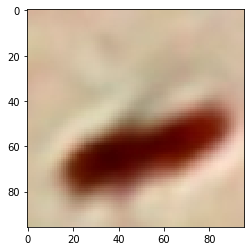

In [29]:
a=data_train.img_paths[0]
img=cv2.imread("/home/marcpozzo/Desktop/c3po/Images_aquises/Rec_images/DSCF0029_incertain_0.JPG")
plt.imshow(img)
img.shape
img=cv2.resize(img,(28,28))

In [74]:
dictionnaire=train_generator.class_indices
dictionnaire

{'autre': 0,
 'chevreuil': 1,
 'corneille': 2,
 'faisan': 3,
 'lapin': 4,
 'oiseau': 5,
 'pigeon': 6,
 'tracteur': 7,
 'voiture': 8}

In [23]:
convert_image(a)

SystemError: <built-in function imread> returned NULL without setting an error

In [139]:
dictionnaire_inv = {v: k for k, v in dictionnaire.items()}
dictionnaire_inv

{0: 'autre',
 1: 'chevreuil',
 2: 'corneille',
 3: 'faisan',
 4: 'lapin',
 5: 'oiseau',
 6: 'pigeon',
 7: 'tracteur',
 8: 'voiture'}

In [182]:
arr=range(0,9)
df=pd.DataFrame({"int_cat": arr})
df["str_cat"]="None"
for i in range(9):
    df["str_cat"].iloc[i]=dictionnaire_inv[df["int_cat"].iloc[i]]
df.to_csv("conversion_cat_generator.csv",index=False)

In [184]:
a=pd.read_csv("conversion_cat_generator.csv")

,int_cat,str_cat
0,0,autre
1,1,chevreuil
2,2,corneille
3,3,faisan
4,4,lapin
5,5,oiseau
6,6,pigeon
7,7,tracteur
8,8,voiture


In [145]:
Keys=[]
Values=[]

for i in range(len(prediction_train)):
    Keys.append(prediction_train[i])
    Values.append(dictionnaire_inv[prediction_train[i]])

In [158]:
print(metrics.classification_report(Y_train, Values))

              precision    recall  f1-score   support

       autre       0.62      0.88      0.73      2380
   chevreuil       0.00      0.00      0.00       109
   corneille       0.42      0.02      0.04       835
      faisan       0.04      0.00      0.01       268
       lapin       0.00      0.00      0.00       141
      oiseau       0.06      0.37      0.10       173
      pigeon       0.01      0.00      0.00       662
    tracteur       0.00      0.00      0.00       113
     voiture       0.00      0.00      0.00       106

    accuracy                           0.46      4787
   macro avg       0.13      0.14      0.10      4787
weighted avg       0.39      0.46      0.37      4787



In [161]:
#Avec argmax ....
intermediate_layer_model = Model(input=lenet.input, output=lenet.layers[-1].output)

X_train_features = intermediate_layer_model.predict(preprocess_input(X_train_img))
arg_predict=X_train_features.argmax(axis=1)

Values=[]

for i in range(len(arg_predict)) :
    Keys.append(arg_predict[i])
    Values.append(dictionnaire_inv[arg_predict[i]])

print(metrics.classification_report(Y_train, Values))

/home/marcpozzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("de...)`
  


              precision    recall  f1-score   support

       autre       0.98      0.96      0.97      2380
   chevreuil       0.98      0.98      0.98       109
   corneille       0.91      0.96      0.93       835
      faisan       0.96      0.96      0.96       268
       lapin       0.84      0.90      0.87       141
      oiseau       0.84      0.69      0.76       173
      pigeon       0.93      0.97      0.95       662
    tracteur       0.96      0.99      0.97       113
     voiture       1.00      0.99      1.00       106

    accuracy                           0.95      4787
   macro avg       0.93      0.93      0.93      4787
weighted avg       0.95      0.95      0.95      4787



In [70]:
df=pd.read_csv(generateur_path)
df.shape

(6220, 3)

In [162]:
#Avec argmax ....
intermediate_layer_model = Model(input=lenet.input, output=lenet.layers[-1].output)

X_test_features = intermediate_layer_model.predict(preprocess_input(X_test_img))
arg_predict=X_test_features.argmax(axis=1)

Values=[]

for i in range(len(arg_predict)) :
    Keys.append(arg_predict[i])
    Values.append(dictionnaire_inv[arg_predict[i]])

print(metrics.classification_report(Y_test, Values))

              precision    recall  f1-score   support

       autre       0.95      0.96      0.95       595
   chevreuil       0.89      0.89      0.89        27
   corneille       0.85      0.89      0.87       209
      faisan       0.84      0.78      0.81        67
       lapin       0.62      0.66      0.64        35
      oiseau       0.42      0.33      0.37        43
      pigeon       0.91      0.89      0.90       166
    tracteur       0.90      0.93      0.91        28
     voiture       1.00      1.00      1.00        27

    accuracy                           0.89      1197
   macro avg       0.82      0.81      0.82      1197
weighted avg       0.89      0.89      0.89      1197



/home/marcpozzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("de...)`
  
